# Homework 2 : Data from the web

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import requests                # Handle HTTP request
from bs4 import BeautifulSoup  # Pull data out of HTML and XML files
import time
import glob                    # Load files
import re                      # Regexp
import scipy.stats as stats    # Hypothesis Testing
import matplotlib.pyplot as plt

## I - Scraping Data 

This part aims to scrap IS-Academia Data. We get Informatique students from 2007 to 2016 for each Bachelor and Master semester.

### a - Analysing form

In this first part, we get the form paramters (name and values) in order to build future HTTP requests.

In [3]:
base_url = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS'
form_url= base_url + ".filter"
form_get_params = {'ww_i_reportModel': '133685247'}
r = requests.get(form_url, params=form_get_params)
print(r.status_code)                                  # Status code = 200 => OK

200


In [4]:
soup = BeautifulSoup(r.text, 'html.parser')
inputs = soup.select('form select')               # Get all the form inputs
for i in range(len(inputs)):
    print('Param ',i+1,' : ',inputs[i]['name'])

Param  1  :  ww_x_UNITE_ACAD
Param  2  :  ww_x_PERIODE_ACAD
Param  3  :  ww_x_PERIODE_PEDAGO
Param  4  :  ww_x_HIVERETE


In [5]:
for i in range(len(inputs)):
    options = inputs[i].select('option')
    print('Param ',i+1,' : ',inputs[i]['name'], ' - ', len(options), 'values')
    for j in range(len(options)):
        if len(options[j].contents) == 0:
            print('Null', ' - Value : ',options[j]['value'])
        else:
            print(options[j].contents[0], ' - Value : ',options[j]['value'])
    print('\n')

Param  1  :  ww_x_UNITE_ACAD  -  20 values
Null  - Value :  null
Architecture  - Value :  942293
Chimie et génie chimique  - Value :  246696
Cours de mathématiques spéciales  - Value :  943282
EME (EPFL Middle East)  - Value :  637841336
Génie civil  - Value :  942623
Génie mécanique  - Value :  944263
Génie électrique et électronique   - Value :  943936
Humanités digitales  - Value :  2054839157
Informatique  - Value :  249847
Ingénierie financière  - Value :  120623110
Management de la technologie  - Value :  946882
Mathématiques  - Value :  944590
Microtechnique  - Value :  945244
Physique  - Value :  945571
Science et génie des matériaux  - Value :  944917
Sciences et ingénierie de l'environnement  - Value :  942953
Sciences et technologies du vivant  - Value :  945901
Section FCUE  - Value :  1574548993
Systèmes de communication  - Value :  946228


Param  2  :  ww_x_PERIODE_ACAD  -  11 values
Null  - Value :  null
2016-2017  - Value :  355925344
2015-2016  - Value :  213638028
20

### b - Scraping Data

In [6]:
def saveHTML(params, file):
    "Get the result of a request -which parameters are given in params- and save it into a file"
    
    base_url = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS'   
    data_url = base_url + ".html"
    
    form_params = {'ww_x_GPS': '-1', 
                  'ww_i_reportModel': '133685247', 
                  'ww_i_reportModelXsl': '133685270', # HTML
                  'ww_x_UNITE_ACAD': '249847', # Informatique
                  'ww_x_PERIODE_ACAD': '', 
                  'ww_x_PERIODE_PEDAGO': '',
                  'ww_x_HIVERETE': None }
    for key, value in params.items():
        form_params[key] = value
        
    r = requests.get(data_url, params=form_params)

    html_file = open(file, "w")
    html_file.write(r.text)
    html_file.close()
    
    return r 

In [7]:
def scrapBachelor():
    "Scrap the Bachelor Data from 2007 to 2016 for each pedagogic semester"
    
    params = {'ww_x_PERIODE_ACAD':'', 'ww_x_PERIODE_PEDAGO':''}
    ww_x_PERIODE_ACAD = {'2016':'355925344','2015':'213638028','2014':'213637922','2013':'213637754','2012':'123456101',
                        '2011':'123455150','2010 ':'39486325','2009 ':'978195','2008 ':'978187','2007 ':'978181'}
    ww_x_PERIODE_PEDAGO = {'BS1':'249108','BS2':'249114','BS3':'942155','BS4':'942163','BS5':'942120','BS6':'942175'}
    
    for key_acad, value_acad in ww_x_PERIODE_ACAD.items():
        for key_peda, value_peda in ww_x_PERIODE_PEDAGO.items():
            params['ww_x_PERIODE_ACAD'] = value_acad
            params['ww_x_PERIODE_PEDAGO'] = value_peda
            filename = "./data/Bachelor/Informatique_"+key_acad.rstrip()+"_"+key_peda+".html"
            saveHTML(params, filename)
            time.sleep(0.05)
            
scrapBachelor()

In [8]:
def scrapMaster():
    "Scrap the Master Data from 2007 to 2016 for each pedagogic semester (and project)"
    
    params = {'ww_x_PERIODE_ACAD':'', 'ww_x_PERIODE_PEDAGO':'', 'ww_x_HIVERETE':''}
    ww_x_PERIODE_ACAD = {'2016':'355925344','2015':'213638028','2014':'213637922','2013':'213637754','2012':'123456101',
                        '2011':'123455150','2010 ':'39486325','2009 ':'978195','2008 ':'978187','2007 ':'978181'}
    ww_x_PERIODE_PEDAGO = {'MS1':'2230106','MS2':'942192','MS3':'2230128','MS4':'2230140',
                           'ProjetAutomne':'249127','ProjetPrintemps':'3781783'}
    ww_x_HIVERETE = {'Automne':'2936286', 'Printemps':'2936295'} # For the masters, we take the season into account
    
    for key_acad, value_acad in ww_x_PERIODE_ACAD.items():
        for key_hiv, value_hiv in ww_x_HIVERETE.items():
            for key_peda, value_peda in ww_x_PERIODE_PEDAGO.items():
                params['ww_x_PERIODE_ACAD'] = value_acad
                params['ww_x_PERIODE_PEDAGO'] = value_peda
                params['ww_x_HIVERETE'] = value_hiv
                filename = "./data/Master/Informatique_"+key_acad.rstrip()+"_"+key_hiv+"_"+key_peda+".html"
                saveHTML(params, filename)
                time.sleep(0.05)
scrapMaster()

### c - Parsing HTML

In [9]:
def parseHTML(file_content):
    "Convert the HTML table into a DataFrame"
    table = BeautifulSoup(file_content, 'html.parser').find('table')
    rows_html = table.findAll('tr')
    if(len(rows_html)>1):
        header = [th.string for th in rows_html[1]] # row[0] is the title
        # we drop the last column (empty) and the first row (header)
        rows = [[td.string for td in row_html.findAll('td')][:-1] for row_html in rows_html[2:]]
        return pd.DataFrame(data=rows, columns=header)
    else:
        return None

In [10]:
def get_file_content(file_path):
    "Read a file content and return it as a string"
    file = open(file_path, "r")
    file_content = file.read()
    file.close() 
    return file_content

In [11]:
def getYearSemesterBachelor(file_path):      # file_path example : './ApoData/Bachelor/Informatique_2007 _BS1.html'
    "Retrieve the year and the semester associated to a Bachelor file using its name"
    year = int(re.search("[0-9]{4}", file_path).group(0))
    num_semester = int(re.findall("[0-9]", file_path)[-1])
    return year, num_semester

In [12]:
def getYearSemesterSeasonMaster(file_path): # example : './ApoData/Master/Informatique_2011_Printemps_MS2.html'
    "Retrieve the year, the season and the semester associated to a Master file using its name"
    #file_name = file_path.split('\\')[1].split('.')[0]
    file_name = file_path.split('/')[3].split('.')[0]
    unit, year, season, num_semester = file_name.split('_')
    if num_semester.find('Projet')!=-1:      
        num_semester = 'Projet'
    else:
        num_semester = int(re.findall("[0-9]", num_semester)[0])
    return int(year), season, num_semester

## II - Analysing Bachelor Data

### a - Loading the data

Bachelor Data are loaded from the HTML files previously scrapped.<br/>
Each HTML table is converted to a dataframe thanks to the <i>parseHTML</i> function.<br/>
Year and Bachelor Semester are also added to the dataFrame.<br/>
Then, the tables are concatenated by rows (which is an easy operation because all the dataframes have the same form).

In [13]:
def loadBachelorData():
    folder_path = "./data/Bachelor"
    paths_iterator = glob.iglob(folder_path+'/*.html')
    for idx, file_path in enumerate(paths_iterator):
        file_content = get_file_content(file_path)
        df_temp = parseHTML(file_content)
        year, num_semester = getYearSemesterBachelor(file_path)
        df_temp['Year'] = year
        df_temp['Bachelor Semester'] = num_semester
        if idx == 0:
            df = df_temp
        else: 
            df = pd.concat([df,df_temp], axis=0)
    return df

In [14]:
df = loadBachelorData()
df.to_csv("Bachelor.csv")
df.head()

,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No Sciper,Year,Bachelor Semester
0,Monsieur,Amruthalingam Ludovic Hadrien,None,None,None,None,None,Présent,None,None,194178,2011,3
1,Monsieur,Angel Axel,None,None,None,None,None,Présent,None,None,201284,2011,3
2,Monsieur,Antognini Marco,None,None,None,None,None,Présent,None,None,194182,2011,3
3,Monsieur,Babst Timo Philip,None,None,None,None,None,Présent,None,None,201232,2011,3
4,Monsieur,Bastin Cédric,None,None,None,None,None,Présent,None,None,204179,2011,3


Now, we want to keep the students who get their Bachelor.<br/>
In order to do this, we check if the students have at least one entry for Bachelor Semester 1 and Bachelor Semester 6 (otherwise, we consider that the student failed).<br/>
We will see later the problems we can encounter by applying this method naively.

In [15]:
def semesterOneToSix(sciper, df):
    "Tell if a student has entry for both Bachelor Semester 1 and Semester 6, and his number of Bachelor semesters"
    
    # Get all the semesters of a student
    studentSemesters = df.loc[df['No Sciper'] == sciper] # = df[df.isin([sciper])['No Sciper']]
    # Check semester 1 and 6
    semesterOne = studentSemesters.isin([1])['Bachelor Semester'].value_counts() 
    semesterSix = studentSemesters.isin([6])['Bachelor Semester'].value_counts()
    # At least one 1st and 6th semester
    if (True in semesterOne.keys() and semesterOne[True] > 0) and (True in semesterSix.keys() and semesterSix[True] > 0): 
        return True, len(studentSemesters)
    else:
        return False, len(studentSemesters)

We build a new DataFrame with all the information we need : the student sciper, the gender and the numbers of Bachelor semesters of each student who succeed his Bachelor.

In [16]:
success_bachelor = {'No Sciper': [], 'Gender': [], 'Number of semesters': []}
for row in df.iterrows():
    sciper = row[1]['No Sciper']
    if not (sciper in success_bachelor['No Sciper']):
        success, nb_semesters = semesterOneToSix(sciper, df)
        if success:             # Only the students who have entry for semester 1 and 6
            success_bachelor['No Sciper'].append(sciper)
            success_bachelor['Gender'].append(row[1]['Civilité'])
            success_bachelor['Number of semesters'].append(nb_semesters)      

In [17]:
success_bachelor = pd.DataFrame(success_bachelor)
success_bachelor.head()

,Gender,No Sciper,Number of semesters
0,Monsieur,201284,6
1,Monsieur,194182,8
2,Monsieur,201232,6
3,Monsieur,204179,6
4,Monsieur,204569,6


In [18]:
initial_number_of_students = len(df['No Sciper'].drop_duplicates())
print(initial_number_of_students, len(success_bachelor))

1482 397


We kept 397 of 1481 initial students. Some of them may have failed, some other could be exchange students, and some could have been victims of missing data.

In [19]:
success_bachelor['Number of semesters'].describe()

count    397.000000
mean       7.083123
std        1.524428
min        4.000000
25%        6.000000
50%        6.000000
75%        8.000000
max       12.000000
Name: Number of semesters, dtype: float64

According to this data, it takes approximately 7 semesters to a student to complete de Bachelor<br/>
Besides, we observe that the minimum of semesters necessary to complete the Bachelor is 4 instead of 6.

In [20]:
success_bachelor.loc[success_bachelor['Number of semesters'] < 6]

,Gender,No Sciper,Number of semesters
265,Monsieur,204222,4


Only one student is concerned. Let's have a look at him :

In [21]:
def getStudentSemesters(df, sciper):
    "Get all the bachelor semesters of a student"
    
    return df.loc[df['No Sciper'] == sciper]

In [22]:
getStudentSemesters(df, '204222')

,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No Sciper,Year,Bachelor Semester
95,Monsieur,Séguy Louis Marie James,None,None,None,None,None,Présent,None,None,204222,2014,6
116,Monsieur,Séguy Louis Marie James,None,None,None,None,None,Présent,None,None,204222,2014,5
108,Monsieur,Séguy Louis Marie James,None,None,None,None,None,Présent,None,None,204222,2011,2
149,Monsieur,Séguy Louis Marie James,None,None,None,None,None,Présent,None,None,204222,2011,1


Semesters 4 and 5 are missing, just as years 2012 an 2013. We can suppose that this student is an outlier caused by missing data in IS-Academia.<br/>
So, we chose to delete it in order to not distort the stats:

In [23]:
outlier_index = success_bachelor.loc[success_bachelor['Number of semesters'] < 6].index
success_bachelor = success_bachelor.drop(outlier_index)
len(success_bachelor.loc[success_bachelor['Number of semesters'] < 6])

0

### b - Hypothesis Testing

We want to know if the male and female students need the same time to go from de 1st semester to the 6th semester.

In [24]:
men=success_bachelor.loc[success_bachelor['Gender'] == 'Monsieur']
men.describe()

,Number of semesters
count,367.000000
mean,7.114441
std,1.530379
min,6.000000
25%,6.000000
50%,6.000000
75%,8.000000
max,12.000000


In [25]:
women=success_bachelor.loc[success_bachelor['Gender'] == 'Madame']
women.describe()

,Number of semesters
count,29.000000
mean,6.793103
std,1.346406
min,6.000000
25%,6.000000
50%,6.000000
75%,8.000000
max,11.000000


- We observe that male are represented by 368 students whereas female are only 29.
- The women need on average 6.8 semesters whereas the men need 7.1 semester.<br/>
The difference is quite small, and the quantiles are the same for both of the groups.<br/>
- Let's see if the difference in average statistically significant.

Let's apply Hypothesis Testing:<br/>
- <b>H0</b> : mean(female) = mean(male)
- <b>H1</b> : mean(female) != mean(male)

Our test statistic is therefore mean(female) - mean(male)<br/>
As we compare 2 populations, we chose to use a <b>two-sample t-test</b>. For this test, we say the variances are different because we observed different std in the 2 precedent tables.<br/>

In [26]:
stats.ttest_ind(a=women['Number of semesters'], b=men['Number of semesters'], equal_var=False)

Ttest_indResult(statistic=-1.224269038658671, pvalue=0.22927095396453964)

We obtain a p-value = 0.22 > 0.05. Therefore, we keep the null hypothesis (H0) and conclude that the difference in average isn't statistically significant with a significance level of 0.05.

<b>Filtering Data</b>

Up to now, we considered that :
- a student succeeded his Bachelor if he had an entry for both Bachelor semester 1 and 6. 
- the number of his Bachelor semesters was egal to his number of entries.

However, there are 2 problems :
- A student who made his Bachelor semester 1 in 2007 can have made another semester 1 in 2006.
- A student who made a Bachelor semester 5 in 2016 and not Bachelor semester 6 in 2015 is likely to make 2 extra semesters. 

In [27]:
df2 = df

# unique index
id_range = np.array(range(len(df)))
df2.index = id_range
df2.index.is_unique

True

We get the No Sciper of students who registered to a Bachelor semester 1 in 2007 and who didn't make a second semester 1 in 2008 (we can't make 3 times the same semester)

In [28]:
index_2007 = df2.loc[df['Year'] == 2007].index
index_2008 = df2.loc[df['Year'] == 2008].index
index_ba1 = df2.loc[df['Bachelor Semester'] == 1].index

index_ba1_2007 = np.intersect1d(index_2007,index_ba1)
index_ba1_2008 = np.intersect1d(index_2008,index_ba1)

sciper_ba1_2007 = df2.iloc[index_ba1_2007]['No Sciper'] # here, iloc and df2.index are the same
sciper_ba1_2008 = df2.iloc[index_ba1_2008]['No Sciper']

sciper_ba1_2007_without_ba1_2008 = np.setdiff1d(sciper_ba1_2007, sciper_ba1_2008)

len(sciper_ba1_2007), len(sciper_ba1_2008), len(sciper_ba1_2007_without_ba1_2008)

(90, 96, 76)

We get the No Sciper of students who registered to a Bachelor semester 5 in 2016 and who didn't make semester 6 in 2015.

In [29]:
index_2015 = df2.loc[df['Year'] == 2015].index
index_2016 = df2.loc[df['Year'] == 2016].index
index_ba5 = df2.loc[df['Bachelor Semester'] == 5].index
index_ba6 = df2.loc[df['Bachelor Semester'] == 6].index

index_ba6_2015 = np.intersect1d(index_2015,index_ba6)
index_ba5_2016 = np.intersect1d(index_2016,index_ba5)

sciper_ba6_2015 = df2.iloc[index_ba6_2015]['No Sciper']
sciper_ba5_2016 = df2.iloc[index_ba5_2016]['No Sciper']

sciper_ba6_2015_and_ba5_2016 = np.setdiff1d(sciper_ba5_2016, sciper_ba6_2015)

len(sciper_ba6_2015), len(sciper_ba5_2016), len(sciper_ba6_2015_and_ba5_2016)

(104, 119, 88)

If we note :
- A : The ensemble of the students who have an entry for both semester 1 and 6
- B : The union of the students to drop

Then we obtain sciper of the students to keep by A\B.

In [30]:
sciperToDrop = np.union1d(sciper_ba1_2007_without_ba1_2008, sciper_ba6_2015_and_ba5_2016)
sciperDropped = np.intersect1d(sciperToDrop, success_bachelor['No Sciper'])
sciperToKeep = np.setdiff1d(success_bachelor['No Sciper'], sciperDropped)
len(sciperToDrop), len(sciperDropped), len(success_bachelor), len(sciperToKeep)

(164, 61, 396, 335)

An inner join enables to keep the desired students.

In [31]:
sciperToKeep_df = pd.DataFrame(sciperToKeep, columns=["No Sciper"])
success_bachelor2 = (pd.merge(success_bachelor,sciperToKeep_df, how="inner"))
success_bachelor2.head()

,Gender,No Sciper,Number of semesters
0,Monsieur,201284,6
1,Monsieur,194182,8
2,Monsieur,201232,6
3,Monsieur,204179,6
4,Monsieur,204569,6


The new dataframe is described by the following statistics values :

In [32]:
success_bachelor2.describe()

,Number of semesters
count,335.000000
mean,7.197015
std,1.579241
min,6.000000
25%,6.000000
50%,6.000000
75%,8.000000
max,12.000000


In [33]:
men2=success_bachelor2.loc[success_bachelor2['Gender'] == 'Monsieur']
men2.describe()

,Number of semesters
count,309.000000
mean,7.223301
std,1.592996
min,6.000000
25%,6.000000
50%,6.000000
75%,8.000000
max,12.000000


In [34]:
women2=success_bachelor2.loc[success_bachelor2['Gender'] == 'Madame']
women2.describe()

,Number of semesters
count,26.000000
mean,6.884615
std,1.395046
min,6.000000
25%,6.000000
50%,6.000000
75%,8.000000
max,11.000000


The difference between male and female students is a bit more elevated than previouly, but stays pretty small.

In [35]:
stats.ttest_ind(a=women['Number of semesters'], b=men['Number of semesters'], equal_var=False)

Ttest_indResult(statistic=-1.224269038658671, pvalue=0.22927095396453964)

The two-sample t-test gives a p-value = 0.22 > 0.05.<br/> 
Again, we keep the null hypothesis (H0) and conclude that the difference in average isn't statistically significant with a significance level of 0.05.

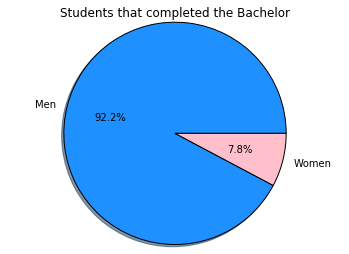

In [36]:
labels = "Men", "Women"
sizes = [men2.size, women2.size]
colors = ["dodgerblue", "pink"]

plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True)
plt.axis('equal')
plt.title("Students that completed the Bachelor")

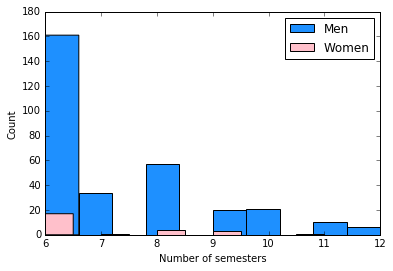

In [37]:
plt.hist(men2["Number of semesters"], facecolor='dodgerblue', alpha = 1, label = "Men")
plt.hist(women2["Number of semesters"], facecolor='pink', alpha = 1, label = "Women")
plt.xlabel("Number of semesters")
plt.ylabel("Count")
plt.legend()


## III - Analysing Master Data

### a - Loading the data

Master Data are loaded from the HTML files previously scrapped.
Each HTML table is converted to a dataframe thanks to the parseHTML function.
Year and Bachelor Semester are also added to the dataFrame.
Then, the tables are concatenated by rows (which is an easy operation because all the dataframes have the same form).

In [38]:
def loadMasterData():
    folder_path = "./data/Master"
    paths_iterator = glob.iglob(folder_path+'/*.html')
    for idx, file_path in enumerate(paths_iterator):
        file_content = get_file_content(file_path)
        df_temp = parseHTML(file_content)
        if not(df_temp is None):    # Some files are empty (especially semester 4)
            year, season, num_semester = getYearSemesterSeasonMaster(file_path)
            df_temp['Year'] = year
            df_temp['Season'] = season
            df_temp['Master Semester'] = num_semester
            if idx == 0:
                df = df_temp
            else: 
                df = pd.concat([df,df_temp], axis=0)
    return df

In [39]:
df = loadMasterData()
df.to_csv("Master.csv")
df.head()

,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No Sciper,Year,Season,Master Semester
0,Monsieur,Aeberhard François-Xavier,None,None,None,None,None,Stage,None,None,153066,2008,Printemps,2
1,Madame,Aydin Ebru,None,None,None,None,None,Présent,None,None,183512,2008,Printemps,2
2,Monsieur,Bakshev Stanimir,None,None,None,None,None,Présent,None,None,185607,2008,Printemps,2
3,Monsieur,Bécholey Alexandre,None,None,None,None,None,Présent,None,None,160213,2008,Printemps,2
4,Madame,Benabdallah Zeineb,None,None,Biocomputing,None,None,Présent,None,None,154573,2008,Printemps,2


Some data are missing. As an example, Master Semester 4 are never registered.

In [40]:
# unique index
id_range = np.array(range(len(df)))
df.index = id_range
df.index.is_unique

True

As some data are missing, we implement some operations on couples (year, season) in order to compute the duration of a master.

In [41]:
def getMinYearSeason(studentSemesters):
    minYear = studentSemesters['Year'].min()
    minYearSemesters = studentSemesters.loc[studentSemesters['Year'] == minYear]
    minSeason = 'Automne' if len(minYearSemesters.loc[minYearSemesters['Season'] == 'Automne']) > 0 else 'Printemps'
    return minSeason, minYear

def getMaxYearSeason(studentSemesters):
    maxYear = studentSemesters['Year'].max()
    maxYearSemesters = studentSemesters.loc[studentSemesters['Year'] == maxYear]
    maxSeason = 'Printemps' if len(maxYearSemesters.loc[maxYearSemesters['Season'] == 'Printemps']) > 0 else 'Automne'
    return maxSeason, maxYear

def getNumberOfSemestersBetweenYearSeason(seasonMin, yearMin, seasonMax, yearMax):
    "Returns the number of semesters between (seasonMin, yearMin) and (seasonMax, yearMax)"
    numberOfSemesters = (yearMax - yearMin)*2
    if seasonMin == 'Automne':
        numberOfSemesters += 2
    else:
        numberOfSemesters += 1
    if seasonMax == 'Automne':
        numberOfSemesters -= 1
    return numberOfSemesters

We wrote some functions in order to manipulates easily students semesters :

In [42]:
def getStudentMasterSemesters(df,sciper):
    "Get all the Master Semester of a student"
    return df.loc[df['No Sciper'] == sciper] # = df[df['No Sciper'].isin([sciper])] = df[df.isin([sciper])['No Sciper']]

def getStudentSemestersN(studentSemesters, no_semester):
    "Get the n-th semesters of a student using his semesters dataframe "
    return studentSemesters.loc[studentSemesters['Master Semester'] == no_semester]

These 2 functions enables to :
- compute the number of semesters between 1st semester 1 and last semester 2 of a student
- compute the number of semesters between the 1st and the last semester of a student

In [43]:
def getMaxDistanceBetweenSemester1And2(studentSemesters):
    "Get the number of semesters between 1st semester 1 and last semester 2"
    semesters_one = getStudentSemestersN(studentSemesters,1)
    semesters_two = getStudentSemestersN(studentSemesters,2)
    if len(semesters_one) > 0 and len(semesters_two) > 0:
        minSeason, minYear = getMinYearSeason(semesters_one)
        maxSeason, maxYear = getMaxYearSeason(semesters_two)
        return getNumberOfSemestersBetweenYearSeason(minSeason, minYear, maxSeason, maxYear)
    else:
        return None

def getNumberOfSemesters(studentSemesters):
    "Get the number of semesters between the 1st and the last semesters"
    minSeason, minYear = getMinYearSeason(studentSemesters)
    maxSeason, maxYear = getMaxYearSeason(studentSemesters)
    return getNumberOfSemestersBetweenYearSeason(minSeason, minYear, maxSeason, maxYear)

Finally, we will need to know if :
- The student did a project during his master
- The data about Mineur are valid
- The student's specialization

In [44]:
def studentHasProject(studentSemesters):
    project_semesters = getStudentSemestersN(studentSemesters, 'Projet')
    if len(project_semesters) > 0:
        return True
    else:
        return False

def studentHasMineur(studentSemesters):
    if (len(studentSemesters['Mineur'].value_counts()) > 0):
        return True
    else:
        return False
    
def studentValidityMineur(studentSemesters):
    "If a Mineur field is not empty, the student should also appear registered in Master semestre 3."
    if studentHasMineur(studentSemesters) == True:
        if len(getStudentSemestersN(studentSemesters, 3)) > 0:
            return True
        else:
            return False
    return True

def studentSpecialisation(studentSemesters):
    semestersWithSpecialization = studentSemesters[studentSemesters['Spécialisation'].notnull()]
    if (len(semestersWithSpecialization) > 0):
        specialization_name = semestersWithSpecialization['Spécialisation'].values[0]
        return specialization_name
    else:
        return None

Features of a valid student :
- He has at least an entry for semester 1 and 2.
- If a Mineur field is not empty, the student should also appear registered in Master semestre 3.
- He made a Projet Semester.

In [45]:
def student_is_valid(df,sciper):
    studentSemesters = getStudentMasterSemesters(df,sciper)
    semester_one = len(getStudentSemestersN(studentSemesters, 1)) > 0
    semester_two = len(getStudentSemestersN(studentSemesters, 2)) > 0
    mineur_validity = studentValidityMineur(studentSemesters)
    project = studentHasProject(studentSemesters)
    return semester_one and semester_two and mineur_validity and project

Let's build the dataframe of valid students :

In [46]:
valid_students = {'No Sciper': [], 'Gender': [], 'Specialization': [], 
                  'Semesters between M1 and M2':[], 'Number of semesters':[]}

for row in df.iterrows():
    sciper = row[1]['No Sciper']
    if not (sciper in valid_students['No Sciper']):     # no duplicates
        valid = student_is_valid(df, sciper)
        if valid:                                       # valid students only
            studentSemesters = getStudentMasterSemesters(df,sciper)
            valid_students['No Sciper'].append(sciper)
            valid_students['Gender'].append(row[1]['Civilité'])
            valid_students['Specialization'].append(studentSpecialisation(studentSemesters))
            valid_students['Semesters between M1 and M2'].append(getMaxDistanceBetweenSemester1And2(studentSemesters))
            valid_students['Number of semesters'].append(getNumberOfSemesters(studentSemesters))  

In [47]:
valid_master_students = pd.DataFrame(valid_students)
valid_master_students.head()

,Gender,No Sciper,Number of semesters,Semesters between M1 and M2,Specialization
0,Madame,183512,3,2,None
1,Monsieur,160213,5,2,None
2,Madame,154573,6,4,Biocomputing
3,Monsieur,185523,4,2,Internet computing
4,Monsieur,166491,8,6,None


In [48]:
initial_number_of_students = len(df['No Sciper'].drop_duplicates())
print(initial_number_of_students, len(valid_master_students))

977 114


We kept 114 in 977 students.

### b - Analysing Data

In [49]:
valid_master_students['Semesters between M1 and M2'].describe()

count    114.000000
mean       2.912281
std        1.133258
min        2.000000
25%        2.000000
50%        2.000000
75%        4.000000
max        6.000000
Name: Semesters between M1 and M2, dtype: float64

In average, the M1 and M2 are fulfilled after 3 semesters.

In [50]:
valid_master_students['Number of semesters'].describe()

count    114.000000
mean       4.280702
std        1.109164
min        3.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        9.000000
Name: Number of semesters, dtype: float64

The average stay at the EPFL is 4.3 semesters for master students (without taking into account that the M4 is never registered).<br/>
Here, the average stay is only the number of semesters between the 1st and the last registered on IS-Academia.

<b>Specialization</b>

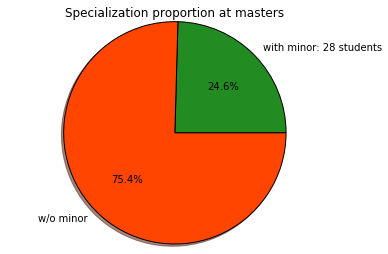

In [51]:
df_valid_with_specialization = valid_master_students[valid_master_students['Specialization'].notnull()]
labels = "with minor: %d students"%len(df_valid_with_specialization), "w/o minor" 

sizes = [len(df_valid_with_specialization), len(valid_master_students) - len(df_valid_with_specialization)]
colors = ["forestgreen", "orangered"]

plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True)
plt.axis('equal')
plt.title("Specialization proportion at masters")

On the 114 valid students, only 28 have specialization.

In [52]:
df_valid_with_specialization['Specialization'].value_counts()

Internet computing                10
Foundations of Software            7
Signals, Images and Interfaces     3
Computer Engineering - SP          2
Software Systems                   2
Information Security - SP          2
Service science                    1
Biocomputing                       1
Name: Specialization, dtype: int64

The samples are very smalls : Indeed, 6 of 8 consists of 3 students or less. By the way, the statistics aren't really reliable for this kind of samples.

In [53]:
df_grouped = df_valid_with_specialization.groupby(df_valid_with_specialization['Specialization'])
df_grouped.mean()
df_valid_with_specialization

,Gender,No Sciper,Number of semesters,Semesters between M1 and M2,Specialization
2,Madame,154573,6,4,Biocomputing
3,Monsieur,185523,4,2,Internet computing
6,Monsieur,146742,9,4,"Signals, Images and Interfaces"
8,Monsieur,186060,4,2,Foundations of Software
9,Monsieur,185522,4,2,Internet computing
18,Monsieur,180072,4,2,Internet computing
20,Monsieur,165819,4,2,Foundations of Software
21,Monsieur,179878,4,2,Internet computing
24,Monsieur,210215,5,4,Internet computing
31,Monsieur,175702,4,2,Foundations of Software


- <b>Semesters between M1 and M2</b><br/>
For the global population, the M1 and M2 are fulfilled after 3 semesters. Here, the tendance is rather 4.
- <b>Number of semesters</b><br/>
The average stay at the EPFL is 4.3 semesters for the global population. Here, the number of semesters is more elevated (5 or 6 semesters, in average)
- <b>Conclusion</b><br/>
Even if the samples of students are too small to be reliable, Master students with Specialization tend to stay more time at the EPFL.

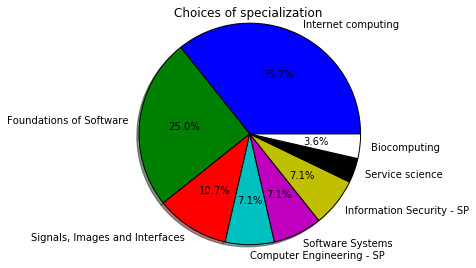

In [54]:
labels = df_valid_with_specialization['Specialization'].value_counts().index

plt.pie(df_valid_with_specialization['Specialization'].value_counts(), labels=labels, autopct='%1.1f%%', shadow=True)

plt.axis('equal')
plt.title("Choices of specialization")

<b>Hypothesis Testing</b>

The specialization's samples are too small too make tests. However, if their size had enabled it, we would have proceed like this :

We want to know the difference in "average stay at the EPFL" is statistically significant between the global master population and each specialization:<br/>
- <b>H0</b> : mean(population) = mean(specialization_n)
- <b>H1</b> : mean(population) != mean(specialization_n)

As we compare the mean of 2 populations (or more accurately, population and subpopulations), we choose to use a <b>two-sample t-test</b> (as previously with Bachelor students).<br/>
In order to work on independant dataframes, we remove students from the n-th specialization from the population dataframe.

In [55]:
specializations = df_valid_with_specialization['Specialization'].drop_duplicates()

def pvalue_signification(pvalue):
    if np.isnan(pvalue):
        return "The sample is too small"
    if pvalue > 0.05:
        return "H0 validated : No significant difference"
    else:
        return "H1 validated : Significant difference"

for specialization in specializations:
    # Removing students from the specialization from the global population
    spe_idx = valid_master_students[valid_master_students['Specialization'] == specialization].index
    pop_without_specialization = valid_master_students.drop(spe_idx)
    
    # Getting the specialization dataframe
    specialization_df = df_valid_with_specialization.loc[df_valid_with_specialization['Specialization'] == specialization]
    
    print(specialization,' - ', len(specialization_df),'students')
    
    # two-sample t-test
    stat, pvalue = stats.ttest_ind(a=pop_without_specialization['Number of semesters'], 
                                   b=specialization_df['Number of semesters'], equal_var=False)
    print('pvalue :', pvalue)
    print(pvalue_signification(pvalue))
    print('\n')

Biocomputing  -  1 students
pvalue : nan
The sample is too small


Internet computing  -  10 students
pvalue : 0.076291762712
H0 validated : No significant difference


Signals, Images and Interfaces  -  3 students
pvalue : 0.367078873668
H0 validated : No significant difference


Foundations of Software  -  7 students
pvalue : 0.123229491401
H0 validated : No significant difference


Information Security - SP  -  2 students
pvalue : 2.6371257522e-10
H1 validated : Significant difference


Computer Engineering - SP  -  2 students
pvalue : 2.6371257522e-10
H1 validated : Significant difference


Software Systems  -  2 students
pvalue : 2.6371257522e-10
H1 validated : Significant difference


Service science  -  1 students
pvalue : nan
The sample is too small




/home/pierre/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
